# Crashspot – Week 2 Starter
**Focus:** Cleaning + Exploratory Mapping (Louisiana & Monroe)

Deliverables this week:
- Refined clean GeoJSONs
- Summary tables & charts (year/month/hour/county)
- KDE heatmaps saved to `outputs/figures/`
- OSM roads downloaded into `data_raw/` (prep for Week 3)



In [1]:
# 0) Setup paths & folders
from pathlib import Path
import os

PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name.startswith('Crashspot_')) else Path.cwd()

for p in ['data_raw', 'data_clean', 'outputs/figures']:
    (PROJECT_ROOT / p).mkdir(parents=True, exist_ok=True)

print('PROJECT_ROOT =', PROJECT_ROOT.resolve())
print('Figures will be saved to:', (PROJECT_ROOT / 'outputs' / 'figures').resolve())

PROJECT_ROOT = /Users/himalranabhat/Desktop/Crashspot
Figures will be saved to: /Users/himalranabhat/Desktop/Crashspot/outputs/figures


In [2]:
# 1) Imports & environment check
import sys, pandas as pd, numpy as np, geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.neighbors import KernelDensity

print('Python:', sys.version.split()[0])
print('pandas', pd.__version__, '| geopandas', gpd.__version__)

Python: 3.12.2
pandas 2.2.2 | geopandas 1.1.1


## Load Week 1 Outputs
Update these paths if you used different names. Monroe file uses the `*_clean.geojson` we created to remove bad coords.

In [3]:
# 2) Load Week 1 cleaned files
la_path = PROJECT_ROOT / 'data_clean' / 'fars_la_2022_2023.geojson'
monroe_path = PROJECT_ROOT / 'data_clean' / 'fars_monroe_2022_2023_clean.geojson'

la_gdf = gpd.read_file(la_path) if la_path.exists() else None
monroe_gdf = gpd.read_file(monroe_path) if monroe_path.exists() else None

print('LA records:', 0 if la_gdf is None else len(la_gdf))
print('Monroe records:', 0 if monroe_gdf is None else len(monroe_gdf))

LA records: 1607
Monroe records: 60


## Clean & Standardize Columns
We'll coerce numeric fields and build a proper datetime for simple grouping.

In [4]:
# 3) Standardize date/time fields and ensure numeric
def prep_df(gdf):
    if gdf is None or gdf.empty:
        return gdf
    df = gdf.copy()
    for c in ['YEAR','MONTH','DAY','HOUR']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
    if all(col in df.columns for col in ['YEAR','MONTH','DAY']):
        dt_parts = df[['YEAR','MONTH','DAY']].astype('float').fillna(1).astype(int)
        df['DATE'] = pd.to_datetime(dict(year=dt_parts['YEAR'], month=dt_parts['MONTH'], day=dt_parts['DAY']), errors='coerce')
    if df.crs is None or df.crs.to_epsg() != 4326:
        df = df.to_crs(4326)
    return df

la_gdf = prep_df(la_gdf)
monroe_gdf = prep_df(monroe_gdf)

print('After prep → LA:', 0 if la_gdf is None else len(la_gdf), '| Monroe:', 0 if monroe_gdf is None else len(monroe_gdf))

After prep → LA: 1607 | Monroe: 60


## Exploratory Summaries
Quick counts by year, month, hour. Modify as needed.

In [5]:
# 4) Summary tables
def summarize(df, label=''):
    if df is None or df.empty: 
        return
    print(f'\n=== {label} ===')
    if 'YEAR' in df: print('By YEAR:\n', df['YEAR'].value_counts().sort_index())
    if 'MONTH' in df: print('\nBy MONTH:\n', df['MONTH'].value_counts().sort_index())
    if 'HOUR' in df: print('\nBy HOUR:\n', df['HOUR'].value_counts().sort_index())
    if 'COUNTY' in df: print('\nTop COUNTIES:\n', df['COUNTY'].value_counts().head(10))

summarize(la_gdf, 'Louisiana')
summarize(monroe_gdf, 'Monroe')


=== Louisiana ===
By YEAR:
 YEAR
2022    852
2023    755
Name: count, dtype: Int64

By MONTH:
 MONTH
1     123
2     123
3     117
4     133
5     137
6     120
7     127
8     138
9     147
10    164
11    124
12    154
Name: count, dtype: Int64

By HOUR:
 HOUR
0      77
1      59
2      64
3      52
4      56
5      61
6      69
7      54
8      42
9      37
10     43
11     42
12     45
13     50
14     46
15     76
16     87
17     92
18     88
19     94
20    111
21    101
22     81
23     76
99      4
Name: count, dtype: Int64

Top COUNTIES:
 COUNTY
33     159
71     130
17      82
105     75
103     71
19      68
51      66
55      65
73      60
63      54
Name: count, dtype: int64

=== Monroe ===
By YEAR:
 YEAR
2022    35
2023    25
Name: count, dtype: Int64

By MONTH:
 MONTH
1      2
2      4
3      4
4      8
5      3
6      4
7      4
8      7
9      8
10     3
11     3
12    10
Name: count, dtype: Int64

By HOUR:
 HOUR
0     3
1     2
3     1
4     1
5     1
6     3
7     

## Simple Charts
Bar charts for month/hour.

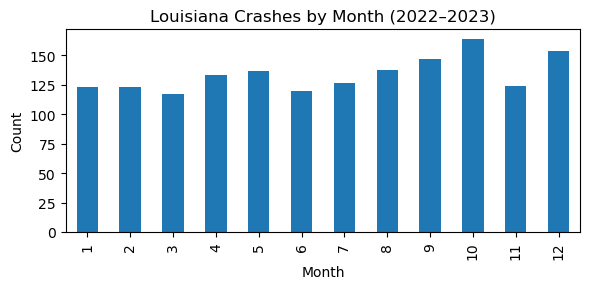

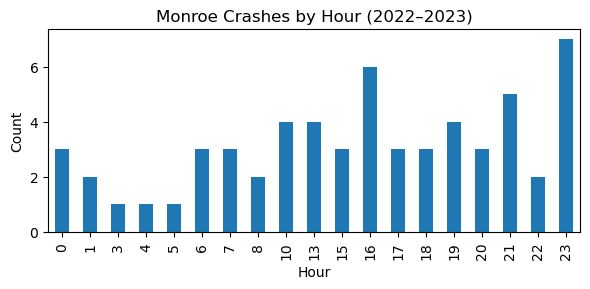

In [6]:
# 5) Bar charts
plt.figure(figsize=(6,3))
if la_gdf is not None and 'MONTH' in la_gdf:
    la_gdf['MONTH'].value_counts().sort_index().plot(kind='bar')
    plt.title('Louisiana Crashes by Month (2022–2023)'); plt.xlabel('Month'); plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'outputs' / 'figures' / 'la_by_month.png', dpi=200)
    plt.show()

plt.figure(figsize=(6,3))
if monroe_gdf is not None and 'HOUR' in monroe_gdf:
    monroe_gdf['HOUR'].value_counts().sort_index().plot(kind='bar')
    plt.title('Monroe Crashes by Hour (2022–2023)'); plt.xlabel('Hour'); plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig(PROJECT_ROOT / 'outputs' / 'figures' / 'monroe_by_hour.png', dpi=200)
    plt.show()

## KDE Heatmap (Python)
This cell computes a simple Kernel Density Estimation over lat/long and saves a raster-like PNG.
Note: For publication-quality heatmaps, also try QGIS → **Raster → Heatmap (Kernel Density Estimation)** with a suitable radius.

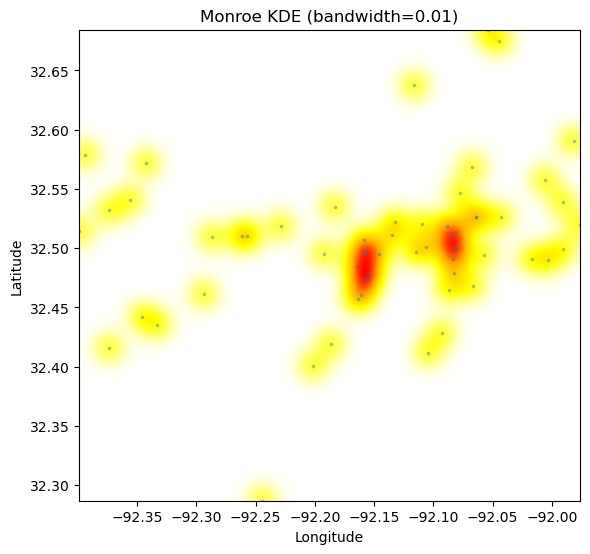

Saved: /Users/himalranabhat/Desktop/Crashspot/outputs/figures/monroe_kde.png


In [7]:
# 6) KDE heatmap for Monroe
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def kde_heatmap(gdf, out_png, bandwidth=0.01, img_size=600):
    if gdf is None or gdf.empty:
        print('No data for KDE.')
        return
    pts = np.vstack([gdf.geometry.y.values, gdf.geometry.x.values]).T  # [lat, lon]
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(pts)
    lat_min, lon_min, lat_max, lon_max = gdf.total_bounds[1], gdf.total_bounds[0], gdf.total_bounds[3], gdf.total_bounds[2]
    xx, yy = np.meshgrid(
        np.linspace(lon_min, lon_max, img_size),
        np.linspace(lat_min, lat_max, img_size)
    )
    sample = np.vstack([yy.ravel(), xx.ravel()]).T
    zz = np.exp(kde.score_samples(sample)).reshape(xx.shape)

    cmap = LinearSegmentedColormap.from_list('kde', ['white','yellow','orange','red'])
    plt.figure(figsize=(6,6))
    plt.imshow(zz, origin='lower', cmap=cmap, extent=[lon_min, lon_max, lat_min, lat_max])
    plt.scatter(gdf.geometry.x, gdf.geometry.y, s=3, alpha=0.3)
    plt.title('Monroe KDE (bandwidth={})'.format(bandwidth))
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()
    print('Saved:', out_png)

kde_out = PROJECT_ROOT / 'outputs' / 'figures' / 'monroe_kde.png'
kde_heatmap(monroe_gdf, kde_out, bandwidth=0.01, img_size=400)

## Download OSM Roads (Prep for Week 3)
- Visit: https://download.geofabrik.de/north-america/us/louisiana.html
- Download **`louisiana-latest-free.shp.zip`** (or `.gpkg`).
- Extract and place files into `data_raw/osm_roads/`.
- We will load and clip these in Week 3.